In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [7]:
# Load CSV using encoding that avoids errors
df = pd.read_csv('water_dataX.csv', encoding='latin1')
df.head()



,STATION CODE,LOCATIONS,STATE,Temp,D.O. (mg/l),PH,CONDUCTIVITY (µmhos/cm),B.O.D. (mg/l),NITRATENAN N+ NITRITENANN (mg/l),FECAL COLIFORM (MPN/100ml),TOTAL COLIFORM (MPN/100ml)Mean,year
0,1393,"DAMANGANGA AT D/S OF MADHUBAN, DAMAN",DAMAN & DIU,30.6,6.7,7.5,203,NAN,0.1,11,27,2014
1,1399,ZUARI AT D/S OF PT. WHERE KUMBARJRIA CANAL JOI...,GOA,29.8,5.7,7.2,189,2,0.2,4953,8391,2014
2,1475,ZUARI AT PANCHAWADI,GOA,29.5,6.3,6.9,179,1.7,0.1,3243,5330,2014
3,3181,RIVER ZUARI AT BORIM BRIDGE,GOA,29.7,5.8,6.9,64,3.8,0.5,5382,8443,2014
4,3182,RIVER ZUARI AT MARCAIM JETTY,GOA,29.5,5.8,7.3,83,1.9,0.4,3428,5500,2014


In [8]:
print(df.columns)
print(df.info())
print(df.describe())

Index(['STATION CODE', 'LOCATIONS', 'STATE', 'Temp', 'D.O. (mg/l)', 'PH',
       'CONDUCTIVITY (µmhos/cm)', 'B.O.D. (mg/l)',
       'NITRATENAN N+ NITRITENANN (mg/l)', 'FECAL COLIFORM (MPN/100ml)',
       'TOTAL COLIFORM (MPN/100ml)Mean', 'year'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1991 entries, 0 to 1990
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   STATION CODE                      1991 non-null   object
 1   LOCATIONS                         1991 non-null   object
 2   STATE                             1991 non-null   object
 3   Temp                              1991 non-null   object
 4   D.O. (mg/l)                       1991 non-null   object
 5   PH                                1991 non-null   object
 6   CONDUCTIVITY (µmhos/cm)           1991 non-null   object
 7   B.O.D. (mg/l)                     1991 non-null   object
 8 

In [10]:
# Convert relevant columns to numeric, coerce errors to NaN
cols_to_convert = [
    'PH',
    'B.O.D. (mg/l)',
    'D.O. (mg/l)',
    'NITRATENAN N+ NITRITENANN (mg/l)',
    'TOTAL COLIFORM (MPN/100ml)Mean'
]

for col in cols_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')


In [11]:
df = df.dropna(subset=cols_to_convert)


In [12]:
df['Safe'] = (
    (df['PH'].between(6.5, 8.5)) &
    (df['B.O.D. (mg/l)'] < 3) &
    (df['D.O. (mg/l)'] > 4) &
    (df['NITRATENAN N+ NITRITENANN (mg/l)'] < 45) &
    (df['TOTAL COLIFORM (MPN/100ml)Mean'] < 10)
).astype(int)

df['Safe'].value_counts()

Safe
0    1629
1      20
Name: count, dtype: int64

In [13]:
df_model = df.drop(['STATION CODE', 'LOCATIONS', 'STATE', 'year'], axis=1)



In [14]:
X = df_model.drop('Safe', axis=1)
y = df_model['Safe']


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [17]:
# Convert all columns in X to numeric, forcing errors (like ' ') to become NaN
X = X.apply(pd.to_numeric, errors='coerce')


In [18]:
# Drop rows with any NaN values
X = X.dropna()
y = y.loc[X.index]  # Align y with cleaned X


In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



In [21]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [22]:
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9968354430379747

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       313
           1       0.75      1.00      0.86         3

    accuracy                           1.00       316
   macro avg       0.88      1.00      0.93       316
weighted avg       1.00      1.00      1.00       316



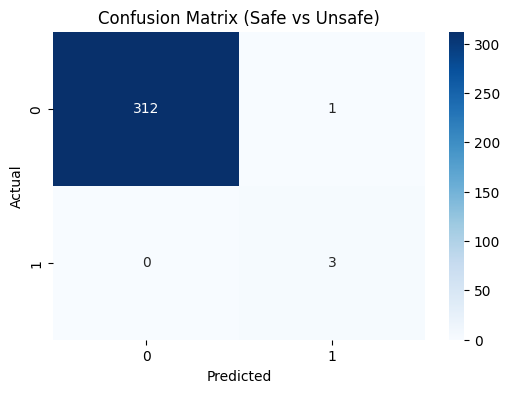

In [23]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Safe vs Unsafe)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


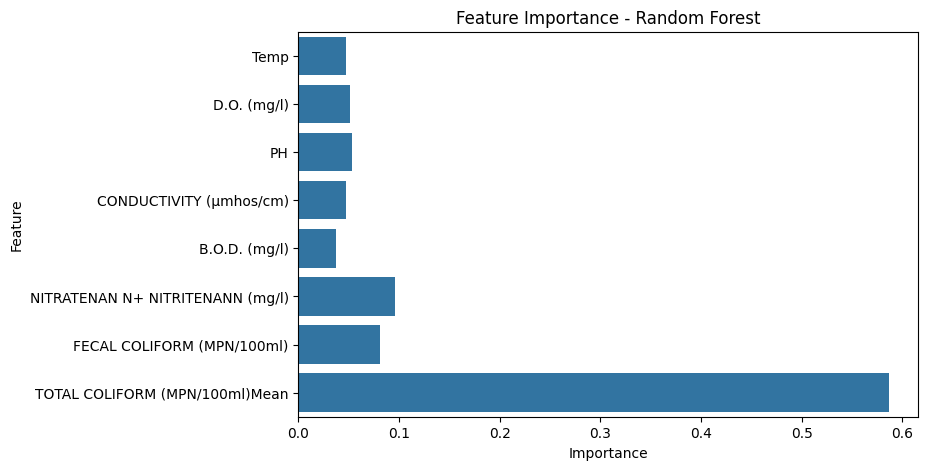

In [24]:
importances = model.feature_importances_
features = X.columns

plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=features)
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()
